## Econ 526 Data Project
Cohen Perratt and Julia Jaynes

In [1]:
import pandas as pd
import numpy as np
from stats_can import StatsCan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from graphviz import Digraph
from sklearn import linear_model
from typing import List
from operator import add
from toolz import reduce, partial
from scipy.optimize import fmin_slsqp

## 1. Directed Acyclical Graph

This will be used to provide justification as for the use in difference in differences model 

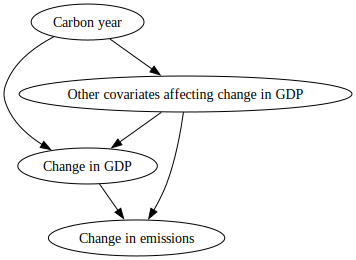

In [2]:
###Let's create a DAG to represent the problems of bias withih the measuring of GDP data:

g = Digraph()
g.edge('Carbon year','Change in GDP')
g.edge('Other covariates affecting change in GDP','Change in GDP')
g.edge('Carbon year','Other covariates affecting change in GDP')
g.edge('Change in GDP','Change in emissions')
g.edge('Other covariates affecting change in GDP','Change in emissions')
g

## 3.1 Difference in Differences Estimation

Here is the corresponding results section from the difference in differences section.

In [3]:
####We want to analyze the pre-trend behavior on the data to ensure that we can use canada as an accurate counterfactual;
###Let's just start with non-log data
sc = StatsCan()
vectors = ['v62788432','v62787278','v62787847']
names = ['BC','Canada','Quebec']
df = sc.vectors_to_df(vectors,start_date='1981')
df.columns = names

#df = df.iloc[:32]
df['Canada'] = df['Canada'] - df['BC'] - df['Quebec']
df=df[['BC','Canada']]


HTTPError: 503 Server Error: Service Unavailable for url: https://www150.statcan.gc.ca/t1/wds/rest/getSeriesInfoFromVector

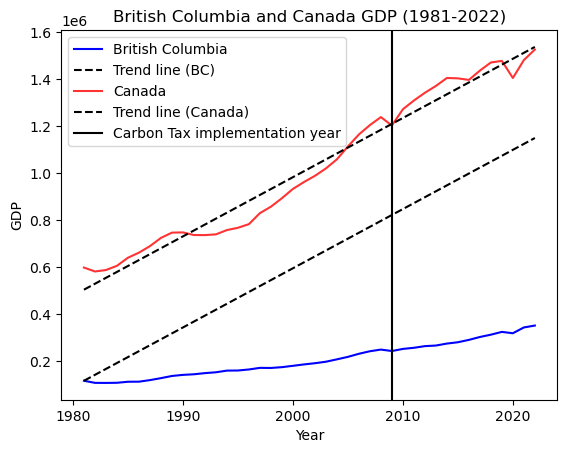

In [ ]:
df['Year'] = df.index.year

x = df['Year']
y_bc = df['BC']
y_canada = df['Canada']

# Fit a linear regression model to the data
coefficients_canada = np.polyfit(x, y_canada, 1)
trend_line_canada = np.polyval(coefficients_canada, x)

#creating line to compare Canada and BC
slope = ((trend_line_canada[-1]-trend_line_canada[0])/(2022-1981))
df['trend_x'] = range((2022-1981)+1)
df['trend_bc'] = y_bc[0] + (slope * df['trend_x'])


# Plot the data and trend lines
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, df['trend_bc'], linestyle='--', color='black', label='Trend line (BC)')

plt.plot(x, y_canada, label='Canada', color='red', alpha=0.8)
plt.plot(x, trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')

# Other plot configurations
plt.axvline(x=df.index[28].year, color='black', label='Carbon Tax implementation year')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('British Columbia and Canada GDP (1981-2022)')
plt.legend()
plt.show()


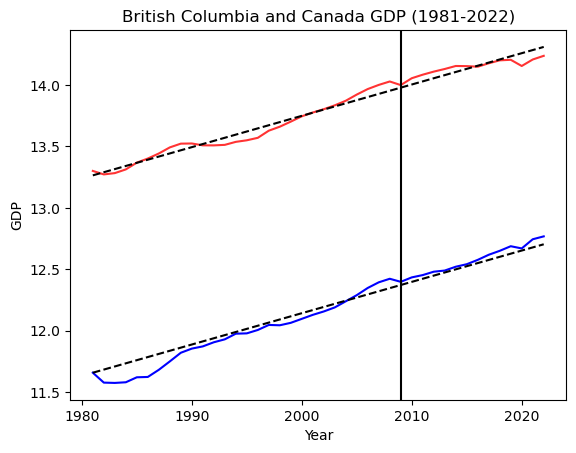

In [ ]:

df['Year'] = df.index.year

x = df['Year']
y_bc = np.log(df['BC'])
y_canada = np.log(df['Canada'])

# Fit a linear regression model to the data
coefficients_canada = np.polyfit(x, y_canada, 1)
trend_line_canada = np.polyval(coefficients_canada, x)

#creating line to compare Canada and BC
slope = ((trend_line_canada[-1]-trend_line_canada[0])/(2022-1981))
df['trend_x'] = range((2022-1981)+1)
df['trend_bc'] = y_bc[0] + (slope * df['trend_x'])

# Plot the data and trend lines
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, df['trend_bc'], linestyle='--', color='black', label='Trend line (BC)')

plt.plot(x, y_canada, label='Canada', color='red', alpha=0.8)
plt.plot(x, trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')

# Other plot configurations
plt.axvline(x=df.index[28].year, color='black', label='Carbon Tax implementation year')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('British Columbia and Canada GDP (1981-2022)')
plt.show()

### Normal DiD Two Periods:

In [ ]:
df = sc.vectors_to_df(vectors,start_date='1981')
df.columns = names
df['Canada'] = df['Canada'] - df['BC'] - df['Quebec']
df=df[['BC','Canada']]

##Log linearize the data
df['BC'] = np.log(df['BC'])
df['Canada'] = np.log(df['Canada'])

new_df = pd.melt(df,var_name='Location',value_name='Value',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC').astype(int)
#First lets add a tax impelemntation dummy to differentiate time 
new_df['tax'] =np.where(new_df.index.year>=2008,1,0)

##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

new_df['R'] = np.where(new_df.index.year.isin([2007,2008,2009]),1,0)
new_df['R*BC'] = new_df['BC'] * new_df['R']

model = smf.ols("Value ~ BC*tax + R*BC",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     317.5
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           2.54e-50
Time:                        20:31:00   Log-Likelihood:                 20.071
No. Observations:                  84   AIC:                            -28.14
Df Residuals:                      78   BIC:                            -13.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5916      0.038    354.735      0.000      13.515      13.668
BC            -1.6533      0.054    -30.511      0.000      -1.761      -1.545
tax            0.5378      0.065      8.308      0.000       0.409       0.667
BC:tax         0.0801      0.092      0.875      0.384      -0.102       0.262
R              0.0603      0.120      0.501      0.618      -0.179       0.300
R:BC          -0.0060      0.170     -0.035      0.972      -0.345       0.333
==============================================================================
Omnibus:                        0.952   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.621   Jarque-Bera (JB):                0.929
Skew:                           0.070   Prob(JB):                        0.628
Kurtosis:                       2.504   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.2: DiD with a year dummy that takes on the value of the tax

In [ ]:
df = sc.vectors_to_df(vectors,start_date='1981')
df.columns = names
#df = df.iloc[:32]
df['Canada'] = df['Canada'] - df['BC'] - df['Quebec']
df=df[['BC','Canada']]
##Let's log linearize variables 
df['BC'] = np.log(df['BC'])
df['Canada'] = np.log(df['Canada'])

new_df = pd.melt(df,var_name='Location',value_name='Value',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC').astype(int)
#First lets add a tax impelemntation dummy to differentiate time
new_df['tax']= np.where(new_df.index.year>=2008,1,0).astype(int)

new_df['year']= np.where(new_df.index.year==2008,10,0)
new_df['year'] += np.where(new_df.index.year.isin([2009]),15,0).astype(int)
new_df['year'] += np.where(new_df.index.year.isin([2010]),20,0).astype(int)
new_df['year'] += np.where(new_df.index.year.isin([2011]),25,0).astype(int)
new_df['year'] += np.where(new_df.index.year.isin([2012, 2013, 2014, 2015, 2016, 2017, 2018]),30,0).astype(int)
new_df['year'] += np.where(new_df.index.year.isin([2019,2020,2021]),40,0).astype(int)
new_df['year'] += np.where(new_df.index.year.isin([2022]),50,0).astype(int)
new_df['year'] += np.where(new_df.index.isin([2023]),65,0).astype(int)
new_df['year'] = np.where(new_df['BC'] == 0, 0, new_df['year']).astype(int)

# ##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

new_df['R'] = np.where(new_df.index.year.isin([2007,2008,2009]),1,0)
new_df['R*BC'] = new_df['BC'] * new_df['R']
##Now let's drop observations after 2019 due to the carbon tax implementation federally
new_df = new_df[new_df.index.year<=2019]
model = smf.ols("Value ~ C(year)*tax + R*BC",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     146.2
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.84e-41
Time:                        20:31:01   Log-Likelihood:                 21.333
No. Observations:                  78   AIC:                            -20.67
Df Residuals:                      67   BIC:                             5.258
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            13.5911      0.038    353.106      0.000      13.514      13.668
C(year)[T.10]        -0.2446      0.145     -1.689      0.096      -0.534       0.044
C(year)[T.15]        -0.2571      0.145     -1.775      0.080      -0.546       0.032
C(year)[T.20]        -0.0036      0.107     -0.034      0.973      -0.218       0.210
C(year)[T.25]         0.0058      0.107      0.054      0.957      -0.208       0.220
C(year)[T.30]         0.0563      0.055      1.022      0.311      -0.054       0.166
C(year)[T.40]         0.1233      0.107      1.150      0.254      -0.091       0.337
tax                   0.5181      0.071      7.327      0.000       0.377       0.659
C(year)[T.10]:tax    -0.2446      0.145     -1.689      0.096      -0.534       0.044
C(year)[T.15]:tax    -0.2571      0.145     -1.775      0.080      -0.546       0.032
C(year)[T.20]:tax    -0.0036      0.107     -0.034      0.973      -0.218       0.210
C(year)[T.25]:tax     0.0058      0.107      0.054      0.957      -0.208       0.220
C(year)[T.30]:tax     0.0563      0.055      1.022      0.311      -0.054       0.166
C(year)[T.40]:tax     0.1233      0.107      1.150      0.254      -0.091       0.337
R                     0.0740      0.122      0.604      0.548      -0.170       0.318
BC                   -1.6682      0.055    -30.464      0.000      -1.777      -1.559
R:BC                  0.3967      0.237      1.677      0.098      -0.075       0.869
==============================================================================
Omnibus:                        0.255   Durbin-Watson:                   0.234
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.435
Skew:                           0.079   Prob(JB):                        0.805
Kurtosis:                       2.670   Cond. No.                     1.29e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.82e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 3.3 Syntehtic Control Model for GDP per capita provinces

This is going to add onto the discussion of the Difference in Differences estimation procedure. We will be using per capita GDP data to compare against our treatment group British Columbia. The idea would be to assign weights to resemble British Columbia's pre-trend data. 

In [ ]:
pop_vec_names = ['Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick',
                 'Quebec','Ontario','Manitoba','Saskatchewan','Alberta','British Columbia','Yukon',
                 'Northwest Territories','Nunavut']
pop_vec_vals = ['v466983','v467298','v467613','v467928','v468243','v468558','v468873','v469188','v469503',
                'v469818','v470133','v479937','v480252']

##Load in the stats canada data
sc = StatsCan()
df_pop = sc.vectors_to_df(pop_vec_vals,start_date='1981')
df_pop.columns = pop_vec_names

In [ ]:
df_pop = df_pop.dropna(axis=1)
df_pop.head()

,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon
REF_DATE,,,,,,,,,,,
1981-01-01,575302.0,123551.0,854871.0,706438.0,6547207.0,8812286.0,1035545.0,975759.0,2291104.0,2826558.0,23880.0
1982-01-01,573795.0,123588.0,859038.0,707457.0,6580631.0,8920288.0,1045224.0,986582.0,2369827.0,2876513.0,24668.0
1983-01-01,579164.0,125102.0,868289.0,714842.0,6602976.0,9039564.0,1059752.0,1001249.0,2393587.0,2907502.0,23664.0
1984-01-01,580065.0,126563.0,877471.0,720488.0,6631220.0,9167484.0,1071810.0,1014615.0,2393907.0,2947181.0,23921.0
1985-01-01,579275.0,127619.0,885848.0,723287.0,6665802.0,9294657.0,1082495.0,1024928.0,2404490.0,2975131.0,24375.0


There is no population data from 1981 - 1990 for Nunavut and NWT so we are going to remove these provinces from teh data set. This will likely not affect our results as the composition of GDP for nunavut and NWT are different from not only BC, but from the rest of Canada

In [ ]:
##Now we want to get GDP data.
gdp_vec_names = ['Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick',
                 'Quebec','Ontario','Manitoba','Saskatchewan','Alberta','British Columbia','Yukon'] 
gdp_vec_vals = ['v62787341','v62787458','v62787575','v62787692','v62787809',
                'v62787926','v62788043','v62788160','v62788277','v62788394',
                'v62788511']

## Load in the Statistics Canada Data
sc = StatsCan()
df_gdp = sc.vectors_to_df(gdp_vec_vals,start_date='1981')
df_gdp.columns = gdp_vec_names
per_capita_gdp = (1000000* df_gdp) / df_pop

Now we want to create a syntehtic control model. We need to develop weights using the pre-trend period. Using the code followed in class: 

In [ ]:
y = per_capita_gdp['British Columbia']
y_pre = y[y.index.year<2008]
x = per_capita_gdp.drop(columns = ["British Columbia",'Yukon','Quebec'])
x_pre = x[x.index.year<2008]

###We are going to use LASSO regression to adjust for overfitting 
weights_lr = linear_model.Lasso(fit_intercept=False).fit(x_pre, y_pre).coef_
weights_lr.round(3)

weights = pd.DataFrame(data = {'Provinces':['Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick',
                 'Ontario','Manitoba','Saskatchewan','Alberta'],'values':weights_lr.round(3)})

weights

/Users/juliajaynes/anaconda3/envs/Econ526/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.816e+06, tolerance: 3.126e+06
  model = cd_fast.enet_coordinate_descent(


,Provinces,values
0,Newfoundland and Labrador,-0.175
1,Prince Edward Island,0.508
2,Nova Scotia,0.635
3,New Brunswick,-0.338
4,Ontario,0.303
5,Manitoba,0.085
6,Saskatchewan,-0.116
7,Alberta,0.071


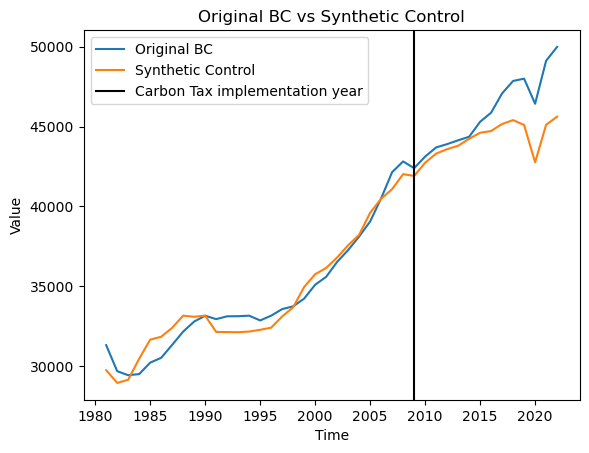

In [ ]:
###Now lets multiply these values by the shortened dataframe w/o BC
synthetic_control = pd.DataFrame(data={'Synthetic_Control': (x * weights_lr).sum(axis=1)})
plt.plot(y, label='Original BC')

# Plot the synthetic control variable
plt.plot(synthetic_control, label='Synthetic Control')
plt.axvline(x=y.index[28], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original BC vs Synthetic Control')
plt.legend()

# Show the plot
plt.show()


In [ ]:
###Lets try this exact same regression but in terms of logs:
y = np.log(per_capita_gdp['British Columbia'])
y_pre = y[y.index.year<2008]
x = np.log(per_capita_gdp.drop(columns = ["British Columbia",'Yukon','Quebec']))
x_pre = x[x.index.year<2008]

weights_lr = linear_model.Lasso(fit_intercept=False).fit(x_pre, y_pre).coef_
weights_lr.round(3)

weights = pd.DataFrame(data = {'Provinces':['Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick','Ontario','Manitoba','Saskatchewan','Alberta'],'values':weights_lr.round(3)})
weights


/Users/juliajaynes/anaconda3/envs/Econ526/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.537e-01, tolerance: 2.935e-01
  model = cd_fast.enet_coordinate_descent(


,Provinces,values
0,Newfoundland and Labrador,0.712
1,Prince Edward Island,0.107
2,Nova Scotia,0.120
3,New Brunswick,0.000
4,Ontario,0.000
5,Manitoba,0.000
6,Saskatchewan,0.000
7,Alberta,0.063


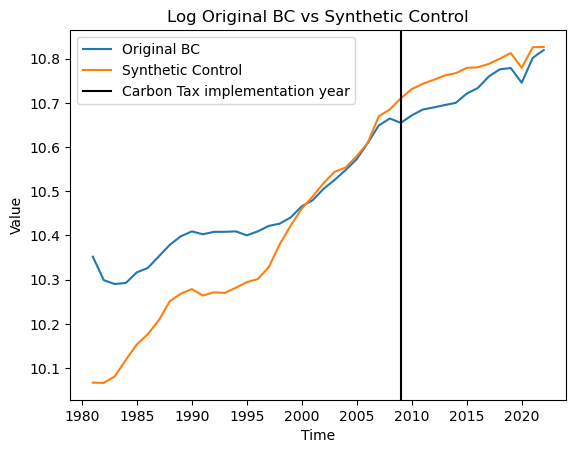

In [ ]:
###Now lets multiply these values by the shortened dataframe w/o BC
synthetic_control = pd.DataFrame(data={'Synthetic_Control': (x * weights_lr).sum(axis=1)})
plt.plot(y, label='Original BC')

# Plot the synthetic control variable
plt.plot(synthetic_control, label='Synthetic Control')
plt.axvline(x=y.index[28], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Log Original BC vs Synthetic Control')
plt.legend()

# Show the plot
plt.show()


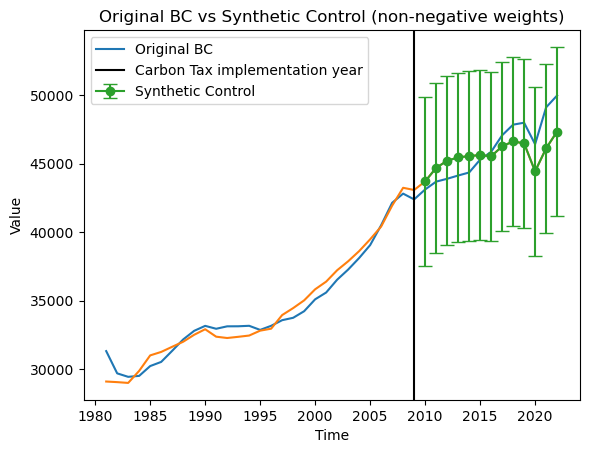

In [ ]:
##We want non-negativeweights: looking at syntehtic control from "causal inference for the brave and true" to get results
y = per_capita_gdp['British Columbia']
y_pre= y[y.index.year<2008]
X = per_capita_gdp.drop(columns = ["British Columbia",'Quebec','Yukon'])
X_pre = X[X.index.year<2008]

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights


synth_nonneg = get_w(X_pre,y_pre)

synth_nonneg

weights = (X * synth_nonneg).round(3)

###Lets create error bars:
y_std = np.std(y)
synth_std = np.std(weights.sum(axis=1))

y_post2008 = y[y.index.year>2009]
weights_post2008 = weights[weights.index.year>2009]


plt.plot(y, label='Original BC')
plt.plot(y.index,weights.sum(axis=1))
# Plot the synthetic control variable
plt.axvline(x=y.index[28], color='black', label='Carbon Tax implementation year')
plt.errorbar(y_post2008.index, weights_post2008.sum(axis=1), yerr=synth_std, label='Synthetic Control', fmt='o-', capsize=5)
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original BC vs Synthetic Control (non-negative weights)')
plt.legend()

# Show the plot
plt.show()

Text(0.5, 1.0, 'ATT of the carbon tax on GDP using synthetic controls')

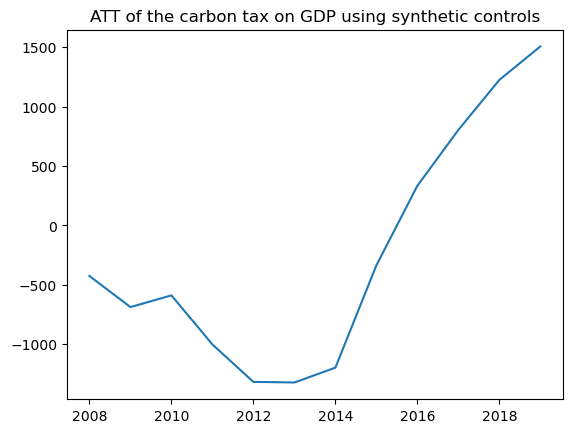

In [ ]:
##Now lets create An ATT for each variable: 
ATT = y - weights.sum(axis=1)
ATT_std = ATT.std()
ATT = ATT[ATT.index.year>=2008]
ATT = ATT[ATT.index.year<=2019]
plt.plot(ATT)
plt.title('ATT of the carbon tax on GDP using synthetic controls')

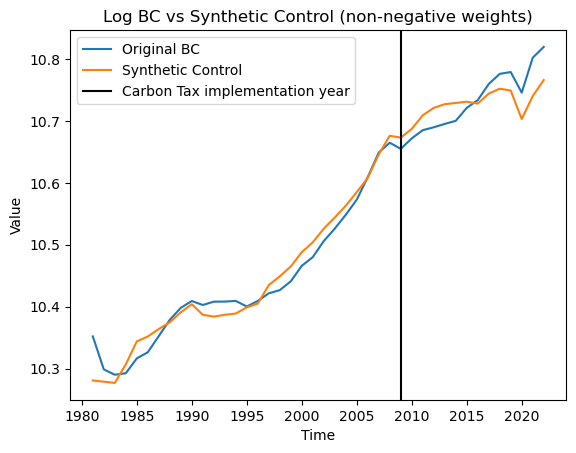

In [ ]:
###Now lets do log controls 
y = np.log(per_capita_gdp['British Columbia'])
y_pre= y[y.index.year<2008]
X = np.log(per_capita_gdp.drop(columns = ["British Columbia",'Quebec','Yukon']))
X_pre = X[X.index.year<2008]

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights


synth_nonneg = get_w(X_pre,y_pre)
synth_nonneg
weights = (X * synth_nonneg).round(3)
plt.plot(y, label='Original BC')
# Plot the synthetic control variable
plt.plot(weights.sum(axis=1), label='Synthetic Control')
plt.axvline(x=y.index[28], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Log BC vs Synthetic Control (non-negative weights)')
plt.legend()

# Show the plot
plt.show()

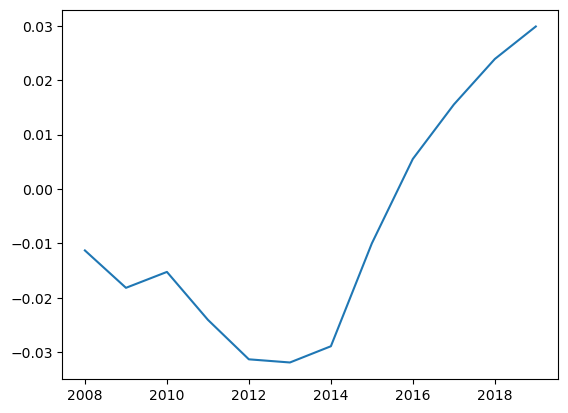

In [ ]:
##Now lets create An ATT for each variable: 
ATT = y - weights.sum(axis=1)
ATT = ATT[ATT.index.year>=2008]
ATT = ATT[ATT.index.year<=2019]
plt.plot(ATT)

3.4 Carbon Emissions Difference in Difference
==============

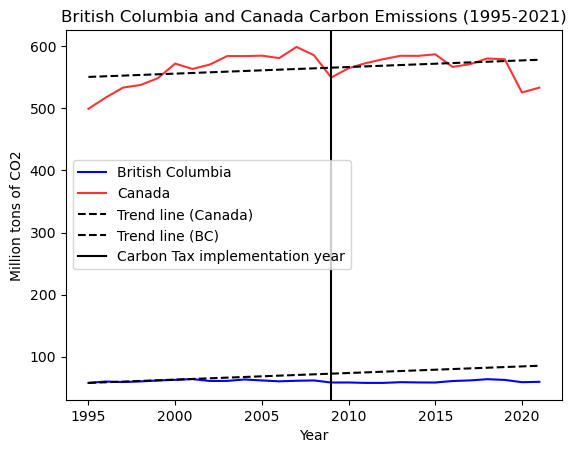

In [ ]:
#Gathering and cleaning data for the carbon analysis
df = pd.read_csv('EN_GHG_Econ_Can_Prov_Terr_CLEAN.csv', header=0)
df_co2 = df.copy()
df_co2['Canada_Total'] = df_co2['Canada_Total'] - df_co2['BC_Total'] - df_co2['Quebec_Total']
df_co2 = df_co2[['Year','BC_Total','Canada_Total']]
df_co2 = df_co2[(df_co2['Year']>=1995)]
df_co2.reset_index(drop=True, inplace=True)

#For graphic fit a linear regression model to the data for control group (Canada)
x = df_co2['Year']
y_bc = df_co2['BC_Total']
y_canada = df_co2['Canada_Total']
coefficients_canada = np.polyfit(x, y_canada, 1)
co2_trend_line_canada = np.polyval(coefficients_canada, x)


#creating line to compare Canada and BC
slope = ((co2_trend_line_canada[-1]-co2_trend_line_canada[0])/(2021-1995))
df_co2['trend_x'] = range((2021-1995)+1)
df_co2['trend_bc'] = y_bc[0] + (slope * df_co2['trend_x'])
co2_trend_line_bc = df_co2['trend_bc']

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Million tons of CO2')
plt.title('British Columbia and Canada Carbon Emissions (1995-2021)')

#plot analysis
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, y_canada, label='Canada', color='red',alpha=0.8)
plt.plot(x, co2_trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')
plt.plot(x, co2_trend_line_bc, linestyle='--', color='black', label='Trend line (BC)')
plt.axvline(x=2009, color='black', label='Carbon Tax implementation year')

# Display the legend & plot
plt.legend(loc='center left')
plt.show()


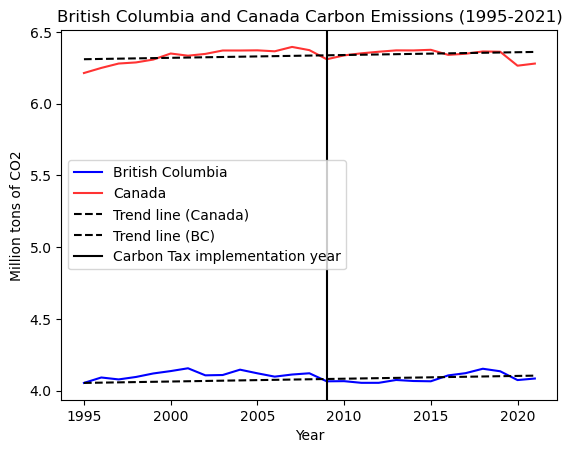

In [ ]:
#Log-Linearize the data
#For graphic fit a log-linear regression model to the data for control group (Canada)
x = df_co2['Year']
y_bc = np.log(df_co2['BC_Total'])
y_canada = np.log(df_co2['Canada_Total'])
coefficients_canada = np.polyfit(x, y_canada, 1)
co2_trend_line_canada = np.polyval(coefficients_canada, x)

#creating line to compare Canada and BC
slope = ((co2_trend_line_canada[-1]-co2_trend_line_canada[0])/(2021-1995))
df_co2['trend_x'] = range((2021-1995)+1)
df_co2['trend_bc'] = y_bc[0] + (slope * df_co2['trend_x'])
co2_trend_line_bc = df_co2['trend_bc']

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Million tons of CO2')
plt.title('British Columbia and Canada Carbon Emissions (1995-2021)')

#plot analysis
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, y_canada, label='Canada', color='red',alpha=0.8)
plt.plot(x, co2_trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')
plt.plot(x, co2_trend_line_bc, linestyle='--', color='black', label='Trend line (BC)')
plt.axvline(x=2009, color='black', label='Carbon Tax implementation year')

# Display the legend & plot
plt.legend(loc='center left')
plt.show()

### Difference in Difference model with the log-linearized data

In [ ]:
#Gathering and log-linearizing the data for the carbon DiD analysis
df_co2['BC_Total'] = np.log(df_co2['BC_Total'])
df_co2['Canada_Total']= np.log(df_co2['Canada_Total'])

new_df = pd.melt(df_co2,id_vars=['Year'], value_vars= ['BC_Total', 'Canada_Total'],var_name='Location',value_name='Emissions',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC_Total').astype(int)

#First lets add a tax implementation dummy to differentiate time 
new_df['tax'] =np.where(new_df['Year']>=2008,1,0)

##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

model = smf.ols("Emissions ~ BC*tax",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Emissions   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.503e+04
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           7.33e-74
Time:                        20:31:04   Log-Likelihood:                 101.08
No. Observations:                  54   AIC:                            -194.2
Df Residuals:                      50   BIC:                            -186.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3262      0.011    589.602      0.000       6.305       6.348
BC            -2.2163      0.015   -146.057      0.000      -2.247      -2.186
tax            0.0172      0.015      1.152      0.255      -0.013       0.047
BC:tax        -0.0380      0.021     -1.802      0.077      -0.080       0.004
==============================================================================
Omnibus:                        4.855   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                3.945
Skew:                          -0.640   Prob(JB):                        0.139
Kurtosis:                       3.342   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Difference in Difference with tax as dummy variable

In [ ]:
#creating data frame for analysis
new_df = pd.melt(df_co2,id_vars=['Year'], value_vars= ['BC_Total', 'Canada_Total'],var_name='Location',value_name='Emissions',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC_Total').astype(int)


#First lets add a tax impelemntation dummy to differentiate time and different tax rates
new_df['tax']= np.where(new_df['Year']>=2008,1,0).astype(int)

new_df['taxrate']= np.where(new_df['Year']==2008,10,0)
new_df['taxrate'] += np.where(new_df['Year'].isin([2009]),15,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2010]),20,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2011]),25,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2012, 2013, 2014, 2015, 2016, 2017, 2018]),30,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2019,2020,2021]),40,0).astype(int)
new_df['taxrate'] = np.where(new_df['BC'] == 0, 0, new_df['taxrate']).astype(int)

# ##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

##Now let's drop observations after 2019 due to the carbon tax implementation federally
new_df = new_df[new_df['Year']<=2019]
model = smf.ols("Emissions ~ C(taxrate)*tax",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Emissions   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     5.773
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           0.000100
Time:                        20:31:04   Log-Likelihood:                -59.777
No. Observations:                  50   AIC:                             135.6
Df Residuals:                      42   BIC:                             150.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.2181      0.171     30.490      0.000       4.873       5.563
C(taxrate)[T.10]        -1.1169      0.454     -2.459      0.018      -2.033      -0.200
C(taxrate)[T.15]        -1.1449      0.454     -2.521      0.016      -2.061      -0.228
C(taxrate)[T.20]        -1.1444      0.454     -2.520      0.016      -2.061      -0.228
C(taxrate)[T.25]        -1.1502      0.454     -2.533      0.015      -2.067      -0.234
C(taxrate)[T.30]        -1.1316      0.208     -5.453      0.000      -1.550      -0.713
C(taxrate)[T.40]        -1.1099      0.454     -2.444      0.019      -2.026      -0.193
tax                      1.1372      0.305      3.734      0.001       0.523       1.752
C(taxrate)[T.10]:tax    -1.1169      0.454     -2.459      0.018      -2.033      -0.200
C(taxrate)[T.15]:tax    -1.1449      0.454     -2.521      0.016      -2.061      -0.228
C(taxrate)[T.20]:tax    -1.1444      0.454     -2.520      0.016      -2.061      -0.228
C(taxrate)[T.25]:tax    -1.1502      0.454     -2.533      0.015      -2.067      -0.234
C(taxrate)[T.30]:tax    -1.1316      0.208     -5.453      0.000      -1.550      -0.713
C(taxrate)[T.40]:tax    -1.1099      0.454     -2.444      0.019      -2.026      -0.193
==============================================================================
Omnibus:                        6.974   Durbin-Watson:                   0.112
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                2.375
Skew:                           0.003   Prob(JB):                        0.305
Kurtosis:                       1.932   Cond. No.                     1.22e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### DID for per-capita emissions

Let's start by generating the per-capita emissions

In [ ]:
#gathering population data
pop_vec_names = ['Canada','Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick',
                 'Quebec','Ontario','Manitoba','Saskatchewan','Alberta','British Columbia','Yukon',
                 'Northwest Territories','Nunavut']
pop_vec_vals = ['v466668','v466983','v467298','v467613','v467928','v468243','v468558','v468873','v469188','v469503',
                'v469818','v470133','v479937','v480252']

##Load in the stats canada data
df_pop = sc.vectors_to_df(pop_vec_vals,start_date='1995')
df_pop.columns = pop_vec_names
df_pop = df_pop.dropna(axis=1).astype(float)

#using the same population data frame as used for GDP but dropping all years prior to 1990 and after 2021 since that is the time bounds for our emissions data 
df_pop = df_pop[(df_pop.index.year>=1995)&(df_pop.index.year<=2021)]
df_pop["Year"]= df_pop.index.year
df_pop = df_pop.reset_index(drop=True)

#since need to start with the data now not log-linearized 
df_co2 = df.copy()
df_co2 = df_co2[(df_co2['Year']>=1995)]
df_co2.reset_index(drop=True, inplace=True)
df_co2['Canada_Total'] = df_co2['Canada_Total'] - df_co2['BC_Total'] - df_co2['Quebec_Total']
df_co2 = df_co2[['Year','BC_Total','Canada_Total', 'Quebec_Total']]

df_per_co2= df_co2.copy()
df_per_co2['BC_Total'] = (df_co2['BC_Total']*1000000) / df_pop['British Columbia']
df_per_co2['Canada_Total'] = ((df_co2['Canada_Total']-df_co2['BC_Total']-df_co2['Quebec_Total'])*1000000) / (df_pop['Canada']-df_pop['British Columbia']-df_pop['Quebec'])
df_per_co2 = df_per_co2[['Year','BC_Total','Canada_Total']]


Now let's run the analysis

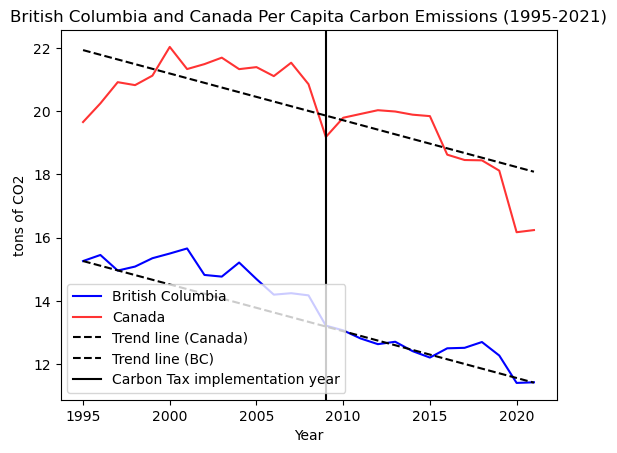

In [ ]:
#For graphic fit a linear regression model to the data for control group (Canada)
x = df_per_co2['Year']
y_bc = df_per_co2['BC_Total']
y_canada = df_per_co2['Canada_Total']
coefficients_canada = np.polyfit(x, y_canada, 1)
co2_trend_line_canada = np.polyval(coefficients_canada, x)

#creating line to compare Canada and BC
slope = ((co2_trend_line_canada[-1]-co2_trend_line_canada[0])/(2021-1995))
df_per_co2['trend_x'] = range((2021-1995)+1)
df_per_co2['trend_bc'] = y_bc[0] + (slope * df_per_co2['trend_x'])
co2_trend_line_bc = df_per_co2['trend_bc']

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('tons of CO2')
plt.title('British Columbia and Canada Per Capita Carbon Emissions (1995-2021)')

#plot analysis
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, y_canada, label='Canada', color='red',alpha=0.8)
plt.plot(x, co2_trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')
plt.plot(x, co2_trend_line_bc, linestyle='--', color='black', label='Trend line (BC)')
plt.axvline(x=2009, color='black', label='Carbon Tax implementation year')

# Display the legend & plot
plt.legend(loc = "lower left")
plt.show()

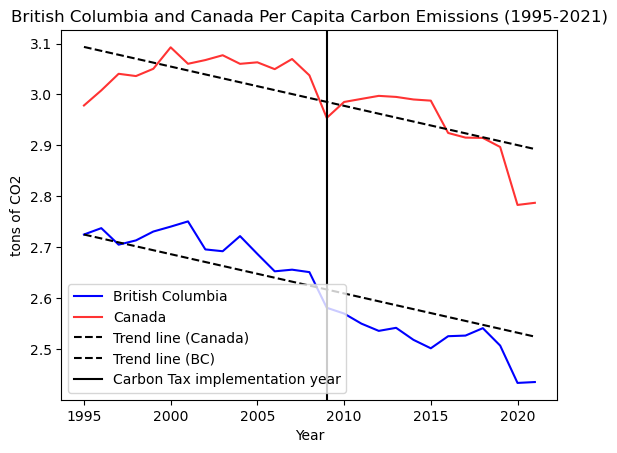

In [ ]:
#Log-Linearize the data
#For graphic fit a log-linear regression model to the data for control group (Canada)
y_bc = np.log(df_per_co2['BC_Total'])
y_canada = np.log(df_per_co2['Canada_Total'])
coefficients_canada = np.polyfit(x, y_canada, 1)
co2_trend_line_canada = np.polyval(coefficients_canada, x)

#creating line to compare Canada and BC
slope = ((co2_trend_line_canada[-1]-co2_trend_line_canada[0])/(2021-1995))
df_per_co2['trend_bc'] = y_bc[0] + (slope * df_per_co2['trend_x'])
co2_trend_line_bc = df_per_co2['trend_bc']

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('tons of CO2')
plt.title('British Columbia and Canada Per Capita Carbon Emissions (1995-2021)')

#plot analysis
plt.plot(x, y_bc, label='British Columbia', color='blue')
plt.plot(x, y_canada, label='Canada', color='red',alpha=0.8)
plt.plot(x, co2_trend_line_canada, linestyle='--', color='black', label='Trend line (Canada)')
plt.plot(x, co2_trend_line_bc, linestyle='--', color='black', label='Trend line (BC)')
plt.axvline(x=2009, color='black', label='Carbon Tax implementation year')

# Display the legend & plo
plt.legend(loc='lower left')
plt.show()

### Difference in Difference model with the per capita data

In [ ]:
#Gathering the data for the GHG emissions per capita  DiD analysis
new_df = pd.melt(df_per_co2,id_vars=['Year'], value_vars= ['BC_Total', 'Canada_Total'],var_name='Location',value_name='Emissions',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC_Total').astype(int)

#First lets add a tax implementation dummy to differentiate time 
new_df['tax'] =np.where(new_df['Year']>=2008,1,0)

##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

model = smf.ols("Emissions ~ BC*tax",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Emissions   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     256.3
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           2.45e-30
Time:                        20:31:06   Log-Likelihood:                -67.877
No. Observations:                  54   AIC:                             143.8
Df Residuals:                      50   BIC:                             151.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.1298      0.245     86.197      0.000      20.637      21.622
BC            -6.1149      0.347    -17.639      0.000      -6.811      -5.419
tax           -2.1615      0.340     -6.349      0.000      -2.845      -1.478
BC:tax        -0.2788      0.481     -0.579      0.565      -1.246       0.688
==============================================================================
Omnibus:                       15.735   Durbin-Watson:                   0.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.036
Skew:                          -1.005   Prob(JB):                     1.64e-05
Kurtosis:                       5.399   Cond. No.                         6.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Difference in Difference with tax as dummy variable

In [ ]:
#creating data frame for analysis
new_df = pd.melt(df_per_co2,id_vars=['Year'], value_vars= ['BC_Total', 'Canada_Total'],var_name='Location',value_name='Emissions',ignore_index=False)
new_df['BC'] = (new_df['Location'] == 'BC_Total').astype(int)


#First lets add a tax impelemntation dummy to differentiate time and different tax rates
new_df['tax']= np.where(new_df['Year']>=2008,1,0).astype(int)

new_df['taxrate']= np.where(new_df['Year']==2008,10,0)
new_df['taxrate'] += np.where(new_df['Year'].isin([2009]),15,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2010]),20,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2011]),25,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2012, 2013, 2014, 2015, 2016, 2017, 2018]),30,0).astype(int)
new_df['taxrate'] += np.where(new_df['Year'].isin([2019,2020,2021]),40,0).astype(int)
new_df['taxrate'] = np.where(new_df['BC'] == 0, 0, new_df['taxrate']).astype(int)

# ##Finally, lets add a BC * tax interaction variable:
new_df['BC*tax'] = new_df['BC']*new_df['tax']

##Now let's drop observations after 2019 due to the carbon tax implementation federally
new_df = new_df[new_df['Year']<=2019]
model = smf.ols("Emissions ~ C(taxrate)*tax",data = new_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Emissions   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     7.384
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           8.87e-06
Time:                        20:31:06   Log-Likelihood:                -111.99
No. Observations:                  50   AIC:                             240.0
Df Residuals:                      42   BIC:                             255.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               18.0724      0.486     37.164      0.000      17.091      19.054
C(taxrate)[T.10]        -2.6271      1.290     -2.036      0.048      -5.231      -0.023
C(taxrate)[T.15]        -3.1056      1.290     -2.407      0.021      -5.710      -0.501
C(taxrate)[T.20]        -3.1804      1.290     -2.465      0.018      -5.785      -0.576
C(taxrate)[T.25]        -3.3084      1.290     -2.564      0.014      -5.913      -0.704
C(taxrate)[T.30]        -3.4522      0.590     -5.855      0.000      -4.642      -2.262
C(taxrate)[T.40]        -3.5785      1.290     -2.773      0.008      -6.183      -0.974
tax                      1.3564      0.865      1.568      0.124      -0.390       3.103
C(taxrate)[T.10]:tax    -2.6271      1.290     -2.036      0.048      -5.231      -0.023
C(taxrate)[T.15]:tax    -3.1056      1.290     -2.407      0.021      -5.710      -0.501
C(taxrate)[T.20]:tax    -3.1804      1.290     -2.465      0.018      -5.785      -0.576
C(taxrate)[T.25]:tax    -3.3084      1.290     -2.564      0.014      -5.913      -0.704
C(taxrate)[T.30]:tax    -3.4522      0.590     -5.855      0.000      -4.642      -2.262
C(taxrate)[T.40]:tax    -3.5785      1.290     -2.773      0.008      -6.183      -0.974
==============================================================================
Omnibus:                        5.365   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                2.099
Skew:                           0.026   Prob(JB):                        0.350
Kurtosis:                       1.998   Cond. No.                     1.22e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 3.5 Syntehtic Control Model for Emissions per capita provinces

This is going to add onto the discussion of the Difference in Differences estimation procedure. We will be using per capita Emissions data to compare against our treatment group British Columbia. The idea would be to assign weights to resemble British Columbia's pre-trend data. 

In [ ]:
#creatihg a new data frame to calculate emissions per capita for all the provinces and territories, we are excluding Northwest Territories and Nunavut since they are not included in the population data frame
df_per_co2 = df.copy().astype(float)
df_per_co2 = df_per_co2.drop(columns="Northwest_Territories_Nunavut_Total")
df_per_co2 = df_per_co2[(df_per_co2['Year']>=1995)]
df_per_co2.reset_index(drop=True, inplace=True)
df_per_co2["Canada_Total"]=(df_per_co2["Canada_Total"]*1000000) / df_pop["Canada"]
df_per_co2["BC_Total"] = (1000000*df_per_co2["BC_Total"])/df_pop["British Columbia"]
df_per_co2["Quebec_Total"] = (df_per_co2["Quebec_Total"]*1000000) / df_pop["Quebec"]
df_per_co2["Newfoundland_and_Labrador_Total"] = (df_per_co2["Newfoundland_and_Labrador_Total"]*1000000) / df_pop["Newfoundland and Labrador"]
df_per_co2["Prince_Edward_Island_Total"] = (df_per_co2["Prince_Edward_Island_Total"]*1000000) / df_pop["Prince Edward Island"]
df_per_co2["Nova_Scotia_Total"] = (1000000*df_per_co2["Nova_Scotia_Total"]) / df_pop["Nova Scotia"]
df_per_co2["New_Brunswick_Total"] = (df_per_co2["New_Brunswick_Total"]*1000000) / df_pop["New Brunswick"]
df_per_co2["Ontario_Total"] = (df_per_co2["Ontario_Total"]*1000000) / df_pop["Ontario"]
df_per_co2["Manitoba_Total"] = (df_per_co2["Manitoba_Total"]*1000000) / df_pop["Manitoba"]
df_per_co2["Saskatchewan_Total"] = (df_per_co2["Saskatchewan_Total"]*1000000) / df_pop["Saskatchewan"]
df_per_co2["Alberta_Total"] = (df_per_co2["Alberta_Total"]*1000000) / df_pop["Alberta"]
df_per_co2["Yukon_Total"] = (df_per_co2["Yukon_Total"]*1000000) / df_pop["Yukon"]

Now we want to create a syntehtic control model. We need to develop weights using the pre-trend period

In [ ]:
df_per_co2.set_index('Year', inplace=True)
y = df_per_co2['BC_Total']
y_pre = y[y.index.values<2008.0]
x = df_per_co2.drop(columns = ["Canada_Total","BC_Total",'Yukon_Total','Quebec_Total'])
x_pre = x[x.index.values<2008.0]


###We are going to use LASSO regression to adjust for overfitting 
weights_lr = linear_model.Lasso(fit_intercept=False).fit(x_pre, y_pre).coef_
weights_lr.round(3)

weights = pd.DataFrame(data = {'Provinces':['Newfoundland_and_Labrador_Total','Prince_Edward_Island_Total','Nova_Scotia_Total','New_Brunswick_Total',
                 'Ontario_Total','Manitoba_Total','Saskatchewan_Total','Alberta_Total'],'values':weights_lr.round(3)})
weights

,Provinces,values
0,Newfoundland_and_Labrador_Total,-0.000
1,Prince_Edward_Island_Total,0.000
2,Nova_Scotia_Total,0.000
3,New_Brunswick_Total,0.000
4,Ontario_Total,0.000
5,Manitoba_Total,0.000
6,Saskatchewan_Total,-0.000
7,Alberta_Total,0.209


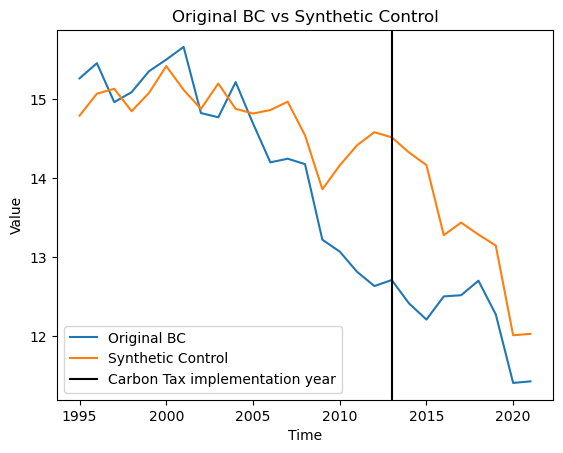

In [ ]:
###Now lets multiply these values by the shortened dataframe w/o BC
synthetic_control = pd.DataFrame(data={'Synthetic_Control': (x * weights_lr).sum(axis=1)})
plt.plot(y, label='Original BC')

# Plot the synthetic control variable
plt.plot(synthetic_control, label='Synthetic Control')
plt.axvline(x=y.index[18], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original BC vs Synthetic Control')
plt.legend()

# Show the plot
plt.show()

Now we will use the log-linearized data as it matched the trends better when we looked at DiD data

                   Provinces  values
0  Newfoundland and Labrador   0.000
1       Prince Edward Island   0.000
2                Nova Scotia   0.000
3              New Brunswick   0.000
4                    Ontario   0.000
5                   Manitoba   0.000
6               Saskatchewan   0.000
7                    Alberta   0.579


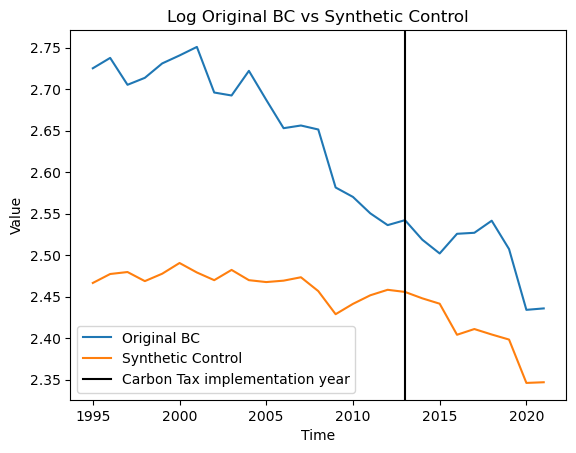

In [ ]:
###Lets try this exact same regression but in terms of logs:
y = np.log(y)
y_pre = np.log(y_pre)
x = np.log(x)
x_pre = np.log(x_pre)

weights_lr = linear_model.Lasso(fit_intercept=False).fit(x_pre, y_pre).coef_
weights_lr.round(3)

#y = np.log(per_capita_gdp['British Columbia'])
#y_pre = y[y.index.year<2008]
#x = np.log(per_capita_gdp.drop(columns = ["British Columbia",'Yukon','Quebec']))
#x_pre = x[x.index.year<2008]

#weights_lr = linear_model.Lasso(fit_intercept=False).fit(x_pre, y_pre).coef_
#weights_lr.round(3)

weights = pd.DataFrame(data = {'Provinces':['Newfoundland and Labrador','Prince Edward Island','Nova Scotia','New Brunswick','Ontario','Manitoba','Saskatchewan','Alberta'],'values':weights_lr.round(3)})
print(weights)

In [ ]:
###Now lets multiply these values by the shortened dataframe w/o BC
synthetic_control = pd.DataFrame(data={'Synthetic_Control': (x * weights_lr).sum(axis=1)})
plt.plot(y, label='Original BC')

# Plot the synthetic control variable
plt.plot(synthetic_control, label='Synthetic Control')
plt.axvline(x=y.index[18], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Log Original BC vs Synthetic Control')
plt.legend()

# Show the plot
plt.show()

### Calculating ATT for the co2 emissions per capita data

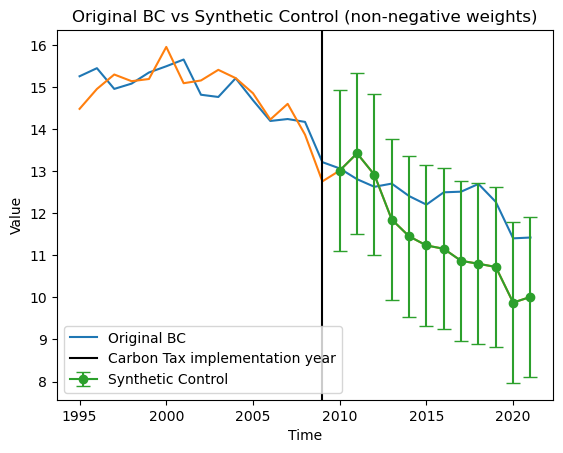

In [ ]:
##We want non-negativeweights: looking at syntehtic control from "causal inference for the brave and true" to get results:
y = df_per_co2['BC_Total']
y_pre= y[y.index.values<2008]
X = df_per_co2.drop(columns = ["BC_Total",'Quebec_Total','Yukon_Total'])
X_pre = X[X.index.values<2008]

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights


synth_nonneg = get_w(X_pre,y_pre)

synth_nonneg

weights = (X * synth_nonneg).round(3)

###Lets create error bars:
y_std = np.std(y)
synth_std = np.std(weights.sum(axis=1))

y_post2008 = y[y.index.values>2009]
weights_post2008 = weights[weights.index.values>2009]


plt.plot(y, label='Original BC')
plt.plot(y.index,weights.sum(axis=1))
# Plot the synthetic control variable
plt.axvline(x=y.index[14], color='black', label='Carbon Tax implementation year')
plt.errorbar(y_post2008.index, weights_post2008.sum(axis=1), yerr=synth_std, label='Synthetic Control', fmt='o-', capsize=5)
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original BC vs Synthetic Control (non-negative weights)')
plt.legend()

# Show the plot
plt.show()



Text(0.5, 1.0, 'ATT of the carbon tax on emissions using synthetic controls')

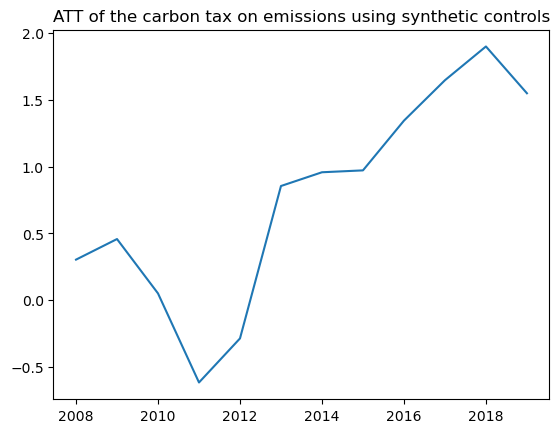

In [ ]:
##Now lets create An ATT for each variable: 
ATT = y - weights.sum(axis=1)
ATT_std = ATT.std()
ATT = ATT[ATT.index.values>=2008]
ATT = ATT[ATT.index.values<=2019]
plt.plot(ATT)
plt.title('ATT of the carbon tax on emissions using synthetic controls')

### Log-linearized data analysis

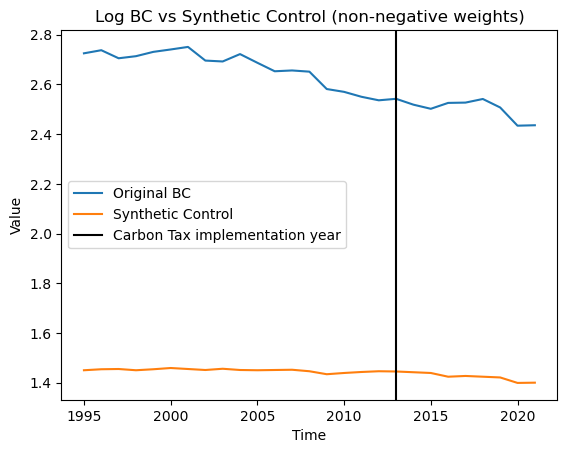

In [ ]:
y = np.log(y)
y_pre= y[y.index.values<2008]
X = np.log(x)
X_pre = X[X.index.values<2008]

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights


synth_nonneg = get_w(X_pre,y_pre)
synth_nonneg
weights = (X * synth_nonneg).round(3)
plt.plot(y, label='Original BC')
# Plot the synthetic control variable
plt.plot(weights.sum(axis=1), label='Synthetic Control')
plt.axvline(x=y.index[18], color='black', label='Carbon Tax implementation year')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Log BC vs Synthetic Control (non-negative weights)')
plt.legend()

# Show the plot
plt.show()

Text(0.5, 1.0, 'ATT of the carbon tax on emissions using synthetic controls for log linearized data')

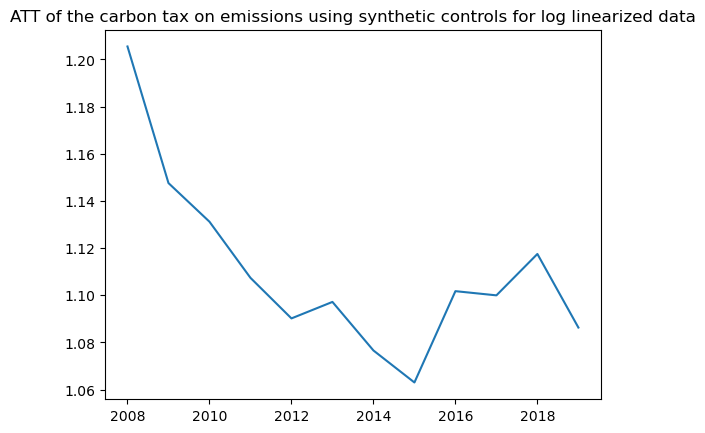

In [ ]:
##Now lets create An ATT for each variable: 
ATT = y - weights.sum(axis=1)
ATT = ATT[ATT.index.values>=2008]
ATT = ATT[ATT.index.values<=2019]
plt.plot(ATT)
plt.title('ATT of the carbon tax on emissions using synthetic controls for log linearized data')

## 4.2: Firm Structure


In [ ]:
###2.2: Firm Structure change in British Columbia

#Data Collection and clean up 
vecs = ['v62356098','v54256094','v54256095',
        'v54256096','v54256097','v54256098',
        'v54256099','v54256100','v54256101',
        'v54256102','v62356099','v62356100',
        'v54256104','v62356101','v54256105',
        'v54256106','v54256107','v54256108',
        'v54256109','v54256110','v54256111']
names = ['Energy sector','Agriculture, forestry, fishing and hunting',
         'Mining, quarrying, and oil and gas extraction','Utilities','Construction','Manufacturing','Wholesale trade',
         'Retail trade','Transportation and warehousing','Information and cultural industries',
         'Finance and insurance','Real estate and rental and leasing','Professional, scientific and technical services',
         'Management of companies and enterprises',
         'Administrative and support, waste management and remediation services',
         'Educational services','Health care and social assistance',
         'Arts, entertainment and recreation','Accommodation and food services',
         'Other services (except public administration)','Public administration']

df = sc.vectors_to_df(vecs,start_date='1991')
df.columns = names

#seperating data into high and low carbon industries
low_carbon_GDP = df[[
               'Information and cultural industries','Finance and insurance', 'Real estate and rental and leasing','Professional, scientific and technical services',
               'Management of companies and enterprises',
                'Administrative and support, waste management and remediation services',
                'Educational services','Health care and social assistance',
                'Arts, entertainment and recreation','Accommodation and food services',
                'Other services (except public administration)','Public administration']]

high_carbon_GDP = df[['Energy sector','Agriculture, forestry, fishing and hunting', 'Retail trade',
                  'Mining, quarrying, and oil and gas extraction','Utilities','Construction', 'Manufacturing', 'Wholesale trade',
                  'Transportation and warehousing']]

Here are some descriptive statistics for the average share of industry before and after the implementation of the tax in 2018.

            Total     Share
REF_DATE                   
1997-01-01  57.48  0.549943
1998-01-01  58.78  0.564758
1999-01-01  57.84  0.554235
2000-01-01  56.08  0.526771
2001-01-01  57.70  0.543110
2002-01-01  58.88  0.559271
2003-01-01  58.86  0.553195
2004-01-01  57.24  0.537465
2005-01-01  56.06  0.516587
2006-01-01  56.68  0.529126
2007-01-01  57.98  0.544464
2008-01-01  58.18  0.536864
2009-01-01  62.20  0.588736
2010-01-01  61.68  0.581229
2011-01-01  60.60  0.564456
2012-01-01  60.59  0.574313
2013-01-01  60.96  0.577929
2014-01-01  60.45  0.572010
2015-01-01  61.68  0.590635
2016-01-01  61.81  0.590805
2017-01-01  60.70  0.575792
2018-01-01  60.62  0.575579
2019-01-01  62.02  0.592303
2020-01-01  62.62  0.599464
2021-01-01  60.72  0.574022
2022-01-01  58.95  0.549138
            Total     Share
REF_DATE                   
1997-01-01  47.04  0.450057
1998-01-01  45.30  0.435242
1999-01-01  46.52  0.445765
2000-01-01  50.38  0.473229
2001-01-01  48.54  0.456890
2002-01-01  46.40  0

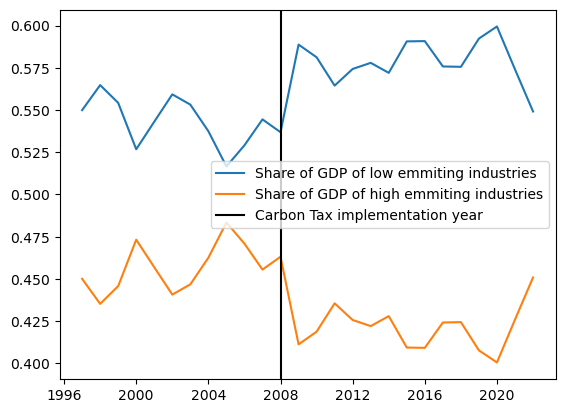

In [ ]:
###Now we want to sum 
low_carbon_sum_df = pd.DataFrame(low_carbon_GDP.sum(axis=1), columns=['Total'])
#low_carbon_sum_df['Total'] = np.log(low_carbon_sum_df['Total'])
high_carbon_sum_df = pd.DataFrame(high_carbon_GDP.sum(axis=1), columns=['Total'])
#high_carbon_sum_df['Total'] = np.log(high_carbon_sum_df['Total'])
total_gdp =pd.DataFrame(df.sum(axis=1),columns = ['Total'])

low_carbon_sum_df['Share'] = low_carbon_sum_df['Total']/total_gdp['Total']
high_carbon_sum_df['Share'] = high_carbon_sum_df['Total']/total_gdp['Total']

print(low_carbon_sum_df)
print(high_carbon_sum_df)

plt.plot(low_carbon_sum_df.index,low_carbon_sum_df['Share'],label='Share of GDP of low emmiting industries')
plt.plot(high_carbon_sum_df.index,high_carbon_sum_df['Share'],label='Share of GDP of high emmiting industries')
plt.axvline(x=low_carbon_sum_df.index[11], color='black', label='Carbon Tax implementation year')
plt.legend()
plt.show()